### Bag-of-Words & TF-IDF Matrix
Bag-of-Words (BoW) places all the words of each text into a 'bucket' or 'bag'. Because of this method, information about the stucture of the sentence is lost. 

TF-IDF stands for Term Frequency - Inverse Document Frequency. TF-IDF scores the relative importance of the words, in order to gain an understanding of the texts as a whole. 

The Term Frequency (TF) is the number of times a word appears in the document, divided by the total number of words in the document.

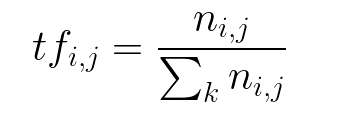

Inverse Document Frequency (IDF) is the log of the number of documents divided by the number of documents that contain a particular word. The IDF finds the weight of rare words across all the documents in the corpus. 

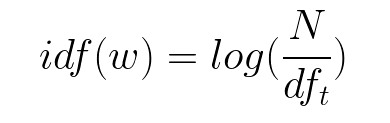

TF-IDF is TF multiplied by IDF. 
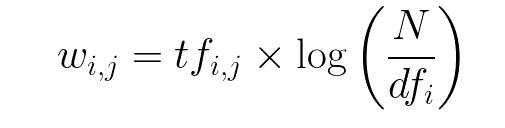

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import re 

from sklearn.decomposition import PCA
from scipy.linalg import norm
from scipy.linalg import eigh as eig

sns.set(style="ticks")
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist #vector pairs
import matplotlib.pyplot as plt

In [90]:
sns.set()
%matplotlib inline

In [91]:
#TFIDF arguments
count_method = 'n' # 'c' or 'n' # n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth

In [92]:
#set OHCO
OHCO = ['text_id', 'author','title','para_num','sent_num','token_num']
TEXTS = OHCO[:3]

In [93]:
#Texts as bag
bag = TEXTS

In [94]:
#import tables
LIB = pd.read_csv('LIB.csv')
VOCAB = pd.read_csv('VOCAB.csv').set_index('term_id')
TOKEN = pd.read_csv('TOKEN.csv')

In [95]:
TOKEN.head()

,text_id,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id
0,1,16,0,0,"('Every', 'DT')",DT,Every,every,15890
1,1,16,0,1,"('art', 'NN')",NN,art,art,2942
2,1,16,0,2,"('and', 'CC')",CC,and,and,1976
3,1,16,0,3,"('every', 'DT')",DT,every,every,15890
4,1,16,0,4,"('inquiry,', 'NN')",NN,"inquiry,",inquiry,23364


In [96]:
LIB.head()

,text_id,title,author,file
0,1,NicomachaenEthics,Aristotle,philostexts\Aristotle_NicomachaenEthics-1.txt
1,4,OnDuties,Cicero,philostexts\Cicero_OnDuties-4.txt
2,5,TheOrderofThings,Foucault,philostexts\Foucault_TheOrderofThings-5.txt
3,6,PedagogyOfTheOppressed,Freire,philostexts\Freire_PedagogyOfTheOppressed-6.txt
4,7,TheOriginsofTotalitarianism,HannahArendt,philostexts\HannahArendt_TheOriginsofTotalitar...


In [97]:
#join LIB to TOKEN table
TOKEN = TOKEN.merge(LIB, on='text_id', how='left')
TOKEN.head()


,text_id,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id,title,author,file
0,1,16,0,0,"('Every', 'DT')",DT,Every,every,15890,NicomachaenEthics,Aristotle,philostexts\Aristotle_NicomachaenEthics-1.txt
1,1,16,0,1,"('art', 'NN')",NN,art,art,2942,NicomachaenEthics,Aristotle,philostexts\Aristotle_NicomachaenEthics-1.txt
2,1,16,0,2,"('and', 'CC')",CC,and,and,1976,NicomachaenEthics,Aristotle,philostexts\Aristotle_NicomachaenEthics-1.txt
3,1,16,0,3,"('every', 'DT')",DT,every,every,15890,NicomachaenEthics,Aristotle,philostexts\Aristotle_NicomachaenEthics-1.txt
4,1,16,0,4,"('inquiry,', 'NN')",NN,"inquiry,",inquiry,23364,NicomachaenEthics,Aristotle,philostexts\Aristotle_NicomachaenEthics-1.txt


In [98]:
#add term rank to VOCAB
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

#groups words by term count
new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'level_0':'term_rank2', 'index':'n', 'n':'nn'})\
    .set_index('n')

VOCAB['term_rank2'] = VOCAB.n.map(new_rank.term_rank2) + 1
VOCAB['p'] = VOCAB.n / VOCAB.shape[0]
VOCAB.head()

,term_rank,term_str,n,num,stop,p_stem,pos_max,term_rank2,p
term_id,,,,,,,,,
44927,1,the,113493,0,1,the,DT,1,2.260817
31100,2,of,71445,0,1,of,IN,2,1.423207
1976,3,and,52889,0,1,and,CC,3,1.053566
45493,4,to,49172,0,1,to,TO,4,0.979522
22446,5,in,37377,0,1,in,IN,5,0.744562


In [99]:
#remove any missing values
VOCAB = VOCAB[~VOCAB.term_str.isna()]
TOKEN = TOKEN[~TOKEN.term_str.isna()]

In [100]:
#BOW
BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})
BOW['c'] = BOW.n.astype('bool').astype('int')
BOW.head()

n  c
text_id author    title             term_id         
1       Aristotle NicomachaenEthics 1        1477  1
                                    2           2  1
                                    6           2  1
                                    11          3  1
                                    70          9  1

In [101]:
#Build count matrix
DTCM = BOW[count_method].unstack().fillna(0).astype('int')
DTCM.head()

,,term_id,1,2,3,4,5,6,7,8,9,10,...,50190,50191,50192,50193,50194,50195,50196,50197,50198,50199
text_id,author,title,,,,,,,,,,,,,,,,,,,,,
1,Aristotle,NicomachaenEthics,1477,2,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,bellhooks,AintIAWoman,1253,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bellhooks,FeministClassStruggle,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cicero,OnDuties,1491,2,0,97,0,4,0,0,0,0,...,0,1,1,1,1,0,0,1,1,2
5,Foucault,TheOrderofThings,3521,0,0,0,0,1,5,3,0,1,...,0,0,0,0,0,0,0,0,0,0


In [102]:
#function to compute TF (Term Frequency)
#group by Bag (TEXT)
def compute_TF(tf_method, DTCM):
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')  
    TF = TF.T  
    return TF

In [103]:
#call function
TF = compute_TF(tf_method, DTCM)
TF.head()

,,term_id,1,2,3,4,5,6,7,8,9,10,...,50190,50191,50192,50193,50194,50195,50196,50197,50198,50199
text_id,author,title,,,,,,,,,,,,,,,,,,,,,
1,Aristotle,NicomachaenEthics,0.017319,0.000023,0.0,0.000000,0.0,0.000023,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000
2,bellhooks,AintIAWoman,0.017515,0.000000,0.0,0.000000,0.0,0.000028,0.000014,0.000000,0.0,0.000000,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000
3,bellhooks,FeministClassStruggle,0.012834,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000
4,Cicero,OnDuties,0.014631,0.000020,0.0,0.000952,0.0,0.000039,0.000000,0.000000,0.0,0.000000,...,0.0,0.00001,0.00001,0.00001,0.00001,0.0,0.0,0.00001,0.00001,0.00002
5,Foucault,TheOrderofThings,0.020401,0.000000,0.0,0.000000,0.0,0.000006,0.000029,0.000017,0.0,0.000006,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000


In [104]:
#Function to compute DF (document frequency) and IDF (inverse document frequency)

def compute_IDF(DTCM, idf_method, DF):
    #compute DF 
    N = DTCM.shape[0] #define shape of matrix
    
    #compute IDF
    if idf_method == 'standard':
        IDF = np.log10(N / DF)
    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 
    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1 
    
    return IDF

In [105]:
DF = DTCM[DTCM > 0].count()
IDF = compute_IDF(DTCM, idf_method, DF)
IDF

term_id
1        0.000000
2        1.000000
3        1.301030
4        0.823909
5        1.301030
           ...   
50195    1.301030
50196    1.301030
50197    1.301030
50198    1.301030
50199    1.301030
Length: 50197, dtype: float64

In [106]:
#compute TF-IDF (term frequency–inverse document frequency)
def compute_TFIDF(TF, IDF):
    TFIDF = TF * IDF
    return TFIDF 

In [107]:
#call TFIDF function
TFIDF = compute_TFIDF(TF, IDF)

In [108]:
TFIDF.head()

,,term_id,1,2,3,4,5,6,7,8,9,10,...,50190,50191,50192,50193,50194,50195,50196,50197,50198,50199
text_id,author,title,,,,,,,,,,,,,,,,,,,,,
1,Aristotle,NicomachaenEthics,0.0,0.000023,0.0,0.000000,0.0,0.000006,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,bellhooks,AintIAWoman,0.0,0.000000,0.0,0.000000,0.0,0.000007,0.000004,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,bellhooks,FeministClassStruggle,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,Cicero,OnDuties,0.0,0.000020,0.0,0.000784,0.0,0.000010,0.000000,0.000000,0.0,0.000000,...,0.0,0.000013,0.000013,0.000013,0.000013,0.0,0.0,0.000013,0.000013,0.000026
5,Foucault,TheOrderofThings,0.0,0.000000,0.0,0.000000,0.0,0.000002,0.000009,0.000012,0.0,0.000008,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [109]:
#add to dataframes
VOCAB['df'] = DF
VOCAB['idf'] = IDF
BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()
#Apply TFIDF sum to VOCAB
VOCAB['tfidf_sum'] = TFIDF.sum()

In [148]:
#save work
VOCAB.to_csv('VOCAB2.csv', index=False)
TOKEN.to_csv('TOKEN2.csv', index=False)
BOW.to_csv('DOC2.csv', index=False)
DTCM.to_csv('DTCM.csv', index=False)
TFIDF.to_csv('TFIDF.csv', index=False)

### Principle Component Analysis (PCA)

In [111]:
VOCAB.head()

,term_rank,term_str,n,num,stop,p_stem,pos_max,term_rank2,p,df,idf,tfidf_sum
term_id,,,,,,,,,,,,
44927,1,the,113493,0,1,the,DT,1,2.260817,20,0.0,0.0
31100,2,of,71445,0,1,of,IN,2,1.423207,20,0.0,0.0
1976,3,and,52889,0,1,and,CC,3,1.053566,20,0.0,0.0
45493,4,to,49172,0,1,to,TO,4,0.979522,20,0.0,0.0
22446,5,in,37377,0,1,in,IN,5,0.744562,20,0.0,0.0


In [112]:
TFIDF.head()

,,term_id,1,2,3,4,5,6,7,8,9,10,...,50190,50191,50192,50193,50194,50195,50196,50197,50198,50199
text_id,author,title,,,,,,,,,,,,,,,,,,,,,
1,Aristotle,NicomachaenEthics,0.0,0.000023,0.0,0.000000,0.0,0.000006,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,bellhooks,AintIAWoman,0.0,0.000000,0.0,0.000000,0.0,0.000007,0.000004,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,bellhooks,FeministClassStruggle,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,Cicero,OnDuties,0.0,0.000020,0.0,0.000784,0.0,0.000010,0.000000,0.000000,0.0,0.000000,...,0.0,0.000013,0.000013,0.000013,0.000013,0.0,0.0,0.000013,0.000013,0.000026
5,Foucault,TheOrderofThings,0.0,0.000000,0.0,0.000000,0.0,0.000002,0.000009,0.000012,0.0,0.000008,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [113]:
#Reduce the number of features by removing insignificant words (based on tfidf_sum). 
#Reduce the set to under 8000 terms.
#Select the top 8000 terms and use them to select the columns of the TFIDF table.
VOCAB_reduced = VOCAB.sort_values('tfidf_sum', ascending=False).head(8000)
TFIDF_reduced = TFIDF[VOCAB_reduced.index]
TFIDF_reduced.head()

,,term_id,44426,41109,17248,49694,4799,5249,49444,19620,32656,47697,...,42699,27486,22741,48189,4806,37791,6702,46029,2760,28723
text_id,author,title,,,,,,,,,,,,,,,,,,,,,
1,Aristotle,NicomachaenEthics,0.0,0.0,0.000000,0.000005,0.000000,0.000000,0.000007,0.0,0.000000,0.000000,...,0.000004,0.000000,0.000012,0.0,0.0,0.000025,0.0,1.089784e-05,0.0,0.000009
2,bellhooks,AintIAWoman,0.0,0.0,0.001347,0.002334,0.006183,0.000000,0.003044,0.0,0.000679,0.000000,...,0.000004,0.000000,0.000000,0.0,0.0,0.000037,0.0,2.598300e-05,0.0,0.000017
3,bellhooks,FeministClassStruggle,0.0,0.0,0.010134,0.003161,0.000000,0.000000,0.001801,0.0,0.003525,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000
4,Cicero,OnDuties,0.0,0.0,0.000000,0.000003,0.000000,0.000000,0.000000,0.0,0.000000,0.004188,...,0.000000,0.000057,0.000000,0.0,0.0,0.000000,0.0,3.040005e-06,0.0,0.000004
5,Foucault,TheOrderofThings,0.0,0.0,0.000000,0.000000,0.000000,0.000007,0.000005,0.0,0.000000,0.000000,...,0.000007,0.000019,0.000010,0.0,0.0,0.000024,0.0,8.975245e-07,0.0,0.000000


In [114]:
VOCAB_reduced.head()

,term_rank,term_str,n,num,stop,p_stem,pos_max,term_rank2,p,df,idf,tfidf_sum
term_id,,,,,,,,,,,,
44426,2068,tao,80,0,0,tao,NNP,659,0.001594,1,1.301030,0.016119
41109,455,siddhartha,373,0,0,siddhartha,NNP,386,0.007430,1,1.301030,0.012358
17248,1093,feminist,160,0,0,feminist,NN,579,0.003187,3,0.823909,0.011530
49694,57,women,3835,0,0,women,NNS,57,0.076394,16,0.096910,0.007868
4799,500,blaek,340,0,0,blaek,NN,412,0.006773,1,1.301030,0.006183


In [115]:
#normalize TFIDF vector lengths
TFIDF_reduced.apply(lambda x: x / norm(x), 1)
#center word vectors
TFIDF_reduced = TFIDF_reduced-TFIDF_reduced.mean()
TFIDF_reduced.head()

,,term_id,44426,41109,17248,49694,4799,5249,49444,19620,32656,47697,...,42699,27486,22741,48189,4806,37791,6702,46029,2760,28723
text_id,author,title,,,,,,,,,,,,,,,,,,,,,
1,Aristotle,NicomachaenEthics,-0.000806,-0.000618,-0.000576,-0.000389,-0.000309,-0.000259,-0.000244,-0.000232,-0.000212,-0.000212,...,-1.227882e-06,-0.000005,0.000007,-0.000005,-0.000005,0.000020,-0.000005,0.000006,-0.000005,4.578956e-06
2,bellhooks,AintIAWoman,-0.000806,-0.000618,0.000771,0.001941,0.005874,-0.000259,0.002794,-0.000232,0.000468,-0.000212,...,-5.497621e-07,-0.000005,-0.000005,-0.000005,-0.000005,0.000032,-0.000005,0.000021,-0.000005,1.193429e-05
3,bellhooks,FeministClassStruggle,-0.000806,-0.000618,0.009557,0.002768,-0.000309,-0.000259,0.001550,-0.000232,0.003313,-0.000212,...,-4.757618e-06,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-4.753158e-06
4,Cicero,OnDuties,-0.000806,-0.000618,-0.000576,-0.000391,-0.000309,-0.000259,-0.000250,-0.000232,-0.000212,0.003976,...,-4.757618e-06,0.000052,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000002,-0.000005,-8.483020e-07
5,Foucault,TheOrderofThings,-0.000806,-0.000618,-0.000576,-0.000393,-0.000309,-0.000252,-0.000245,-0.000232,-0.000212,-0.000212,...,2.219229e-06,0.000014,0.000005,-0.000005,-0.000005,0.000019,-0.000005,-0.000004,-0.000005,-4.753158e-06


In [147]:
TFIDF_reduced.to_csv('TFIDF_reduced.csv', index=False)

In [117]:
#Extract a term covariance matrix (COV) from TFIDF
COV = TFIDF_reduced.cov()
COV.head()

term_id,44426,41109,17248,49694,4799,5249,49444,19620,32656,47697,...,42699,27486,22741,48189,4806,37791,6702,46029,2760,28723
term_id,,,,,,,,,,,,,,,,,,,,,
44426,1.299161e-05,-5.242014e-07,-4.890835e-07,-3.082903e-07,-2.622891e-07,-2.200627e-07,-1.879083e-07,-1.967512e-07,-1.797851e-07,-1.794610e-07,...,-4.036291e-09,-4.036261e-09,-4.036247e-09,-4.036152e-09,-4.034790e-09,-4.034735e-09,-4.033729e-09,-4.033035e-09,-4.032690e-09,-4.032508e-09
41109,-5.242014e-07,7.635553e-06,-3.749486e-07,-2.446340e-07,-2.010800e-07,-1.687078e-07,-1.505077e-07,2.865891e-06,-1.378296e-07,-1.375811e-07,...,1.186289e-08,-3.094340e-09,-3.094329e-09,-3.094256e-09,-3.093212e-09,-3.093170e-09,-3.092398e-09,-3.091866e-09,-3.091602e-09,-3.091462e-09
17248,-4.890835e-07,-3.749486e-07,5.150624e-06,1.613787e-06,2.509012e-07,-1.572735e-07,1.024431e-06,-1.407314e-07,1.799599e-06,-1.283641e-07,...,-2.540840e-09,-2.837197e-09,-2.868673e-09,-2.876391e-09,-2.885988e-09,-2.863421e-10,-2.885229e-09,-1.027989e-09,-2.747417e-09,-1.667797e-09
49694,-3.082903e-07,-2.446340e-07,1.613787e-06,7.528017e-07,6.315449e-07,-8.894268e-08,5.705305e-07,-9.181972e-08,5.828267e-07,-8.696683e-08,...,-1.007784e-09,-1.583510e-09,-1.704231e-09,2.477489e-09,-1.959274e-09,2.598845e-09,-1.588863e-09,1.457715e-09,-9.005367e-10,1.096753e-09
4799,-2.622891e-07,-2.010800e-07,2.509012e-07,6.315449e-07,1.911633e-06,-8.441453e-08,9.091183e-07,-7.547240e-08,1.521647e-07,-6.884002e-08,...,-1.789116e-10,-1.548282e-09,-1.548277e-09,-1.548240e-09,-1.547718e-09,1.034515e-08,-1.547310e-09,6.908721e-09,-1.546912e-09,3.883830e-09


In [118]:
#Apply eigendecomposition to the COV table
#eigh(), since covarience matrix is symmetric
eig_val, eig_vec = eig(COV)

In [119]:
#Combine eigenvalues and eigenvectors into a single table
#convert eigen data to dataframes
term_index = COV.index 
eig_vec_table = pd.DataFrame(eig_vec, index=term_index, columns=term_index)
eig_val_table = pd.DataFrame(eig_val, index=term_index, columns=['eig_val'])
eig_val_table.index.name = 'term_id'

In [120]:
eig_vec_table.head()

term_id,44426,41109,17248,49694,4799,5249,49444,19620,32656,47697,...,42699,27486,22741,48189,4806,37791,6702,46029,2760,28723
term_id,,,,,,,,,,,,,,,,,,,,,
44426,-0.060178,0.108716,-0.208473,0.024272,0.000000,0.029167,-0.039121,0.000000,0.000000,0.000000,...,0.025636,0.008460,-0.020451,0.021952,-0.058582,0.017052,-0.211563,0.034048,-0.259724,0.899484
41109,0.098515,0.072849,-0.097540,-0.112985,0.002971,-0.053448,0.136020,-0.071973,-0.057213,-0.071918,...,0.023495,0.009519,-0.021488,0.024643,-0.067658,0.021713,-0.531287,-0.602140,0.246196,-0.044683
17248,-0.084804,0.355256,0.035744,0.142849,0.127805,0.003096,0.098981,0.018380,0.037742,-0.044735,...,-0.010494,-0.040961,0.001641,-0.003098,0.000151,-0.113476,-0.262637,0.021653,-0.542041,-0.216968
49694,0.407191,-0.158448,-0.183828,-0.164196,0.206712,-0.023769,0.032482,-0.040305,0.044104,-0.110005,...,0.060518,0.278606,0.041015,-0.034480,-0.052778,0.144765,-0.058364,0.005703,-0.187123,-0.082608
4799,0.422933,0.293404,0.137680,0.295051,0.020142,0.128281,-0.053954,0.013601,0.012835,0.029416,...,0.044848,-0.063016,-0.007799,0.018086,-0.221108,0.592021,0.023632,0.000604,-0.070639,-0.042090


In [121]:
eig_val_table.head()

,eig_val
term_id,
44426,-4.027318e-20
41109,-2.149469e-20
17248,-1.626242e-20
49694,-1.125921e-20
4799,-7.616433e-21


In [122]:
#associate each eigenvalue with its corresponding column in the eigenvalue matrix
#transpose eig_vec_table and join tables 
eig_table = eig_val_table.join(eig_vec_table.T)
eig_table.head()

,eig_val,44426,41109,17248,49694,4799,5249,49444,19620,32656,...,42699,27486,22741,48189,4806,37791,6702,46029,2760,28723
term_id,,,,,,,,,,,,,,,,,,,,,
44426,-4.027318e-20,-0.060178,0.098515,-0.084804,0.407191,0.422933,-0.140530,-0.557576,-0.181644,0.225256,...,-0.000004,0.000289,0.000088,-0.001736,0.000754,-0.001936,0.000452,-0.000827,0.000675,-0.002068
41109,-2.149469e-20,0.108716,0.072849,0.355256,-0.158448,0.293404,0.183272,-0.259259,-0.238321,-0.349125,...,0.000709,-0.001358,0.000036,0.001615,0.000514,-0.000446,0.000608,-0.000251,0.001143,0.000417
17248,-1.626242e-20,-0.208473,-0.097540,0.035744,-0.183828,0.137680,0.139343,0.061324,-0.049904,-0.260135,...,0.000294,-0.000822,-0.002714,-0.000439,-0.001596,-0.001684,-0.002488,-0.000867,-0.002836,-0.000540
49694,-1.125921e-20,0.024272,-0.112985,0.142849,-0.164196,0.295051,-0.228761,0.178285,0.357360,-0.105706,...,0.000106,0.003403,-0.000598,0.001895,-0.000118,-0.002767,-0.000526,-0.001613,0.001722,0.000438
4799,-7.616433e-21,0.000000,0.002971,0.127805,0.206712,0.020142,0.216094,-0.001336,0.120824,-0.329566,...,0.000532,0.002986,0.001111,-0.001055,0.001013,-0.000049,0.000465,0.000439,0.003561,-0.000388


In [123]:
#Extract the the top 10 components using explained variance as your metric
eig_table['exp_var'] = np.round((eig_table.eig_val/eig_table.eig_val.sum()) * 100, 2)

top = eig_table.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
top.index.name = 'comp_id'
top.index = ["PC{}".format(i) for i in top.index.tolist()]
top

,eig_val,44426,41109,17248,49694,4799,5249,49444,19620,32656,...,27486,22741,48189,4806,37791,6702,46029,2760,28723,exp_var
PC0,1.442651e-05,0.899484,-0.044683,-0.216968,-0.082608,-0.042090,-0.009603,-0.056238,-0.016771,-0.076923,...,-0.000350,-0.000114,-0.000148,-0.000110,-0.000321,-0.000102,-0.000273,-0.000111,-0.000224,22.76
PC1,1.273266e-05,-0.259724,0.246196,-0.542041,-0.187123,-0.070639,0.016333,-0.128200,0.092406,-0.190916,...,0.001414,0.000238,0.000163,0.000250,-0.000272,0.000240,-0.000063,0.000197,0.000068,20.09
PC2,1.129413e-05,0.034048,-0.602140,0.021653,0.005703,0.000604,-0.001569,0.003237,-0.226004,0.007543,...,0.002690,-0.000020,-0.000017,-0.000012,-0.000004,-0.000027,0.000132,-0.000043,0.000163,17.82
PC3,9.629301e-06,-0.211563,-0.531287,-0.262637,-0.058364,0.023632,0.068028,-0.036322,-0.199411,-0.090422,...,-0.002065,0.000729,0.000710,0.000717,0.000585,0.000710,0.000479,0.000697,0.000455,15.19
PC4,4.623427e-06,0.017052,0.021713,-0.113476,0.144765,0.592021,-0.187590,0.248125,0.008150,-0.019246,...,0.000100,-0.000294,-0.000091,-0.000335,0.003306,-0.000299,0.002295,0.000013,0.001491,7.29
PC5,3.852601e-06,-0.058582,-0.067658,0.000151,-0.052778,-0.221108,-0.496932,-0.099480,-0.025394,-0.007337,...,0.000069,0.001065,0.000962,0.001076,-0.000665,0.001050,-0.000225,0.000923,0.000183,6.08
PC6,1.645072e-06,0.021952,0.024643,-0.003098,-0.034480,0.018086,0.010479,0.006281,0.009249,-0.000733,...,-0.000350,-0.001259,-0.001678,-0.001285,-0.000535,-0.001388,-0.000171,-0.001469,-0.001054,2.60
PC7,1.264120e-06,-0.020451,-0.021488,0.001641,0.041015,-0.007799,-0.001802,-0.008713,-0.008065,0.000678,...,0.000276,0.000792,0.000983,0.001604,-0.000045,0.001762,0.000179,0.001273,0.001494,1.99
PC8,7.090870e-07,0.008460,0.009519,-0.040961,0.278606,-0.063016,0.008412,-0.036485,0.003573,-0.015921,...,-0.001253,-0.003362,0.015601,-0.002071,-0.003249,-0.001432,-0.001590,0.000866,-0.000704,1.12
PC9,6.508140e-07,0.025636,0.023495,-0.010494,0.060518,0.044848,-0.007575,0.015379,0.008818,-0.004625,...,0.001008,0.000995,0.005654,0.000196,0.004559,-0.002374,-0.000729,-0.010319,-0.003288,1.03


In [124]:
#Project the document matrix onto the reduced component space
#creating a document-component table (DCM)
#replaces features of DTM with features of transposed component matrix
DCM = TFIDF_reduced.dot(top[term_index].T)
DCM.head()

,,,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
text_id,author,title,,,,,,,,,,
1,Aristotle,NicomachaenEthics,-0.000314,0.000624,-0.000042,0.001365,-0.000304,0.000826,-0.000403,0.000397,-0.000301,-0.000032
2,bellhooks,AintIAWoman,-0.001866,-0.002764,0.000021,0.000699,0.008411,-0.002618,0.000091,-0.000030,-0.000137,0.000090
3,bellhooks,FeministClassStruggle,-0.005619,-0.012575,0.000456,-0.004841,-0.002103,0.000346,-0.000019,0.000005,-0.000038,-0.000016
4,Cicero,OnDuties,-0.001459,0.005701,0.010237,-0.007611,0.000197,-0.000409,0.000061,-0.000005,0.000016,-0.000004
5,Foucault,TheOrderofThings,-0.000359,0.000605,-0.000002,0.001424,-0.000332,0.000827,-0.000247,-0.000172,-0.001313,0.002506


In [125]:
DCM.reset_index(inplace=True, level = ['author'])
DCM.head()

,,author,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
text_id,title,,,,,,,,,,,
1,NicomachaenEthics,Aristotle,-0.000314,0.000624,-0.000042,0.001365,-0.000304,0.000826,-0.000403,0.000397,-0.000301,-0.000032
2,AintIAWoman,bellhooks,-0.001866,-0.002764,0.000021,0.000699,0.008411,-0.002618,0.000091,-0.000030,-0.000137,0.000090
3,FeministClassStruggle,bellhooks,-0.005619,-0.012575,0.000456,-0.004841,-0.002103,0.000346,-0.000019,0.000005,-0.000038,-0.000016
4,OnDuties,Cicero,-0.001459,0.005701,0.010237,-0.007611,0.000197,-0.000409,0.000061,-0.000005,0.000016,-0.000004
5,TheOrderofThings,Foucault,-0.000359,0.000605,-0.000002,0.001424,-0.000332,0.000827,-0.000247,-0.000172,-0.001313,0.002506


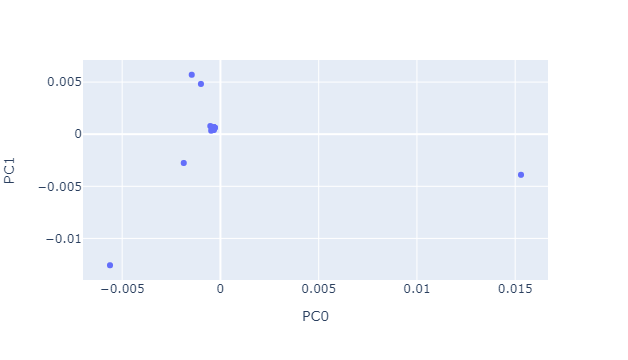

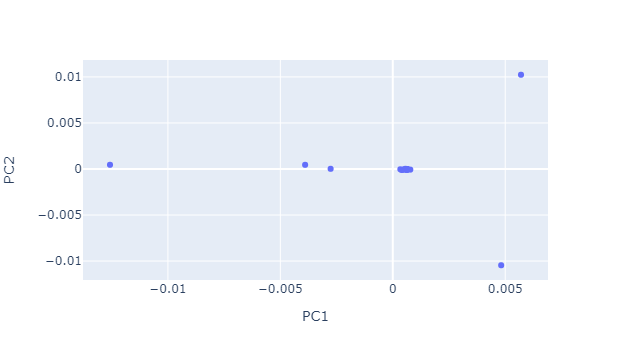

In [126]:
#Visualize results:
#Show a scatter plots of PC0 vs PC1, and PC1 vs PC2
fig1 = px.scatter(DCM, x='PC0', y='PC1')
fig1.show()

fig2 = px.scatter(DCM, x='PC1', y='PC2')
fig2.show()

In [127]:
#Show the positive and negative loadings
#show loadings for top 10 components 
loadings = top[term_index].T
loadings.index.name = 'term_id'
#loadings.head()

loadings['term_str'] = loadings.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

lb0_pos = loadings.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
lb0_neg = loadings.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
lb1_pos = loadings.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
lb1_neg = loadings.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')

print('Texts PC0+', lb0_pos)
print('Texts PC0-', lb0_neg)
print('Texts PC1+', lb1_pos)
print('Texts PC1-', lb1_neg)

Texts PC0+ feminist women patriarchy feminism privileged white workforce reformist siddhartha females
Texts PC0- tao doesnt arent dont overcomes your center nourishes cant yourself
Texts PC1+ feminist tao patriarchy women feminism privileged workforce white reformist supremacist
Texts PC1- siddhartha ut govinda et est autem quae cum quod edd


#### Analysis

### Similarity and Distance Measures by Text Dates
Distances....cityblock	euclidean	cosine	jaccard	dice	js	euclidean2	js2	matching	minkowski

In [128]:
OHCO_src = ['text_id', 'chap_num']
OHCO = ['text_id']

In [129]:
LIB.head()

,text_id,title,author,file
0,1,NicomachaenEthics,Aristotle,philostexts\Aristotle_NicomachaenEthics-1.txt
1,4,OnDuties,Cicero,philostexts\Cicero_OnDuties-4.txt
2,5,TheOrderofThings,Foucault,philostexts\Foucault_TheOrderofThings-5.txt
3,6,PedagogyOfTheOppressed,Freire,philostexts\Freire_PedagogyOfTheOppressed-6.txt
4,7,TheOriginsofTotalitarianism,HannahArendt,philostexts\HannahArendt_TheOriginsofTotalitar...


In [130]:
TFIDF_reduced.head()

,,term_id,44426,41109,17248,49694,4799,5249,49444,19620,32656,47697,...,42699,27486,22741,48189,4806,37791,6702,46029,2760,28723
text_id,author,title,,,,,,,,,,,,,,,,,,,,,
1,Aristotle,NicomachaenEthics,-0.000806,-0.000618,-0.000576,-0.000389,-0.000309,-0.000259,-0.000244,-0.000232,-0.000212,-0.000212,...,-1.227882e-06,-0.000005,0.000007,-0.000005,-0.000005,0.000020,-0.000005,0.000006,-0.000005,4.578956e-06
2,bellhooks,AintIAWoman,-0.000806,-0.000618,0.000771,0.001941,0.005874,-0.000259,0.002794,-0.000232,0.000468,-0.000212,...,-5.497621e-07,-0.000005,-0.000005,-0.000005,-0.000005,0.000032,-0.000005,0.000021,-0.000005,1.193429e-05
3,bellhooks,FeministClassStruggle,-0.000806,-0.000618,0.009557,0.002768,-0.000309,-0.000259,0.001550,-0.000232,0.003313,-0.000212,...,-4.757618e-06,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-4.753158e-06
4,Cicero,OnDuties,-0.000806,-0.000618,-0.000576,-0.000391,-0.000309,-0.000259,-0.000250,-0.000232,-0.000212,0.003976,...,-4.757618e-06,0.000052,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000002,-0.000005,-8.483020e-07
5,Foucault,TheOrderofThings,-0.000806,-0.000618,-0.000576,-0.000393,-0.000309,-0.000252,-0.000245,-0.000232,-0.000212,-0.000212,...,2.219229e-06,0.000014,0.000005,-0.000005,-0.000005,0.000019,-0.000005,-0.000004,-0.000005,-4.753158e-06


#### Text Dates
- TaoTeChing (400 BC)
- OnDuties (44 BC)
- NicomachaenEthics (4th century BC)
- TheRepublic (4th century BC)
- AnEnquiryConcerningHumanUnderstanding (1748)
- MetaphysicsOfMorals (1785)
- AVindicationOfTheRightsofMen (1790)
- AVindicationOfTheRightsofWoman (1792)
- CommunistManifesto (1848)
- EnfranchisementofWomen (1852)
- Utilitarianism (1861)
- BeyondGoodandEvil (1886)
- Siddhartha (1922)
- CollectionOfWritings (1923)
- TheOriginsofTotalitarianism (1951)
- TheSecondSex (1952)
- TheOrderofThings (1966)
- PedagogyOfTheOppressed (1968)
- AintIAWoman (1981)
- FeministClassStruggle (2002)

In [131]:
#Add Date feature to LIB table for each text
LIB.loc[LIB.title.str.contains('NicomachaenEthics'), 'year'] = '0'
LIB.loc[LIB.title.str.contains('TheRepublic'), 'year'] = '0'
LIB.loc[LIB.title.str.contains('OnDuties'), 'year'] = '0'
LIB.loc[LIB.title.str.contains('AnEnquiryConcerningHumanUnderstanding'), 'year'] = '1748'
LIB.loc[LIB.title.str.contains('MetaphysicsOfMorals'), 'year'] = '1785'
LIB.loc[LIB.title.str.contains('CommunistManifesto'), 'year'] = '1848'
LIB.loc[LIB.title.str.contains('Utilitarianism'), 'year'] = '1861'
LIB.loc[LIB.title.str.contains('BeyondGoodandEvil'), 'year'] = '1886'
LIB.loc[LIB.title.str.contains('CollectionOfWritings'), 'year'] = '1923'
LIB.loc[LIB.title.str.contains('TheOrderofThings'), 'year'] = '1966'
LIB.loc[LIB.title.str.contains('TaoTeChing'), 'year'] = '0'
LIB.loc[LIB.title.str.contains('PedagogyOfTheOppressed'), 'year'] = '1968'
LIB.loc[LIB.title.str.contains('Siddhartha'), 'year'] = '1922'
LIB.loc[LIB.title.str.contains('AVindicationOfTheRightsofMen'), 'year'] = '1790'
LIB.loc[LIB.title.str.contains('AVindicationOfTheRightsofWoman'), 'year'] = '1792'
LIB.loc[LIB.title.str.contains('EnfranchisementofWomen'), 'year'] = '1852'
LIB.loc[LIB.title.str.contains('TheSecondSex'), 'year'] = '1952'
LIB.loc[LIB.title.str.contains('TheOriginsofTotalitarianism'), 'year'] = '1951'
LIB.loc[LIB.title.str.contains('AintIAWoman'), 'year'] = '1981'
LIB.loc[LIB.title.str.contains('FeministClassStruggle'), 'year'] = '2002'

In [132]:
LIB

,text_id,title,author,file,year
0,1,NicomachaenEthics,Aristotle,philostexts\Aristotle_NicomachaenEthics-1.txt,0
1,4,OnDuties,Cicero,philostexts\Cicero_OnDuties-4.txt,0
2,5,TheOrderofThings,Foucault,philostexts\Foucault_TheOrderofThings-5.txt,1966
3,6,PedagogyOfTheOppressed,Freire,philostexts\Freire_PedagogyOfTheOppressed-6.txt,1968
4,7,TheOriginsofTotalitarianism,HannahArendt,philostexts\HannahArendt_TheOriginsofTotalitar...,1951
5,8,EnfranchisementofWomen,HarrietTaylorMill,philostexts\HarrietTaylorMill_Enfranchisemento...,1852
6,9,Siddhartha,Hesse,philostexts\Hesse_Siddhartha-9.txt,1922
7,10,AnEnquiryConcerningHumanUnderstanding,Hume,philostexts\Hume_AnEnquiryConcerningHumanUnder...,1748
8,11,MetaphysicsOfMorals,Kant,philostexts\Kant_MetaphysicsOfMorals-11.txt,1785
9,12,CollectionOfWritings,Kierkegaard,philostexts\Kierkegaard_CollectionOfWritings-1...,1923


In [133]:
#collapse TFIDF table
TFIDF = TFIDF_reduced.groupby(OHCO).mean() #average for all terms in book (book as 'bag')
TFIDF.head()

term_id,44426,41109,17248,49694,4799,5249,49444,19620,32656,47697,...,42699,27486,22741,48189,4806,37791,6702,46029,2760,28723
text_id,,,,,,,,,,,,,,,,,,,,,
1,-0.000806,-0.000618,-0.000576,-0.000389,-0.000309,-0.000259,-0.000244,-0.000232,-0.000212,-0.000212,...,-1.227882e-06,-0.000005,0.000007,-0.000005,-0.000005,0.000020,-0.000005,0.000006,-0.000005,4.578956e-06
2,-0.000806,-0.000618,0.000771,0.001941,0.005874,-0.000259,0.002794,-0.000232,0.000468,-0.000212,...,-5.497621e-07,-0.000005,-0.000005,-0.000005,-0.000005,0.000032,-0.000005,0.000021,-0.000005,1.193429e-05
3,-0.000806,-0.000618,0.009557,0.002768,-0.000309,-0.000259,0.001550,-0.000232,0.003313,-0.000212,...,-4.757618e-06,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-4.753158e-06
4,-0.000806,-0.000618,-0.000576,-0.000391,-0.000309,-0.000259,-0.000250,-0.000232,-0.000212,0.003976,...,-4.757618e-06,0.000052,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000002,-0.000005,-8.483020e-07
5,-0.000806,-0.000618,-0.000576,-0.000393,-0.000309,-0.000252,-0.000245,-0.000232,-0.000212,-0.000212,...,2.219229e-06,0.000014,0.000005,-0.000005,-0.000005,0.000019,-0.000005,-0.000004,-0.000005,-4.753158e-06


In [134]:
#create DOC table - stores info related to bags in token table
DOC = TFIDF.reset_index()[OHCO] # We create a table from the OHCO in our TFIDF table
DOC.index.name = 'doc_id' # We give the new index a name
#add title to DOC index
DOC['title'] = DOC.text_id.map(LIB.author) \
    + '-' + DOC[OHCO].apply(lambda x: x.astype('str').str.cat(sep='-'), 1) \
    + ': '+ DOC.text_id.map(LIB.title) 
DOC.head()

term_id,text_id,title
doc_id,,
0,1,Cicero-1: OnDuties
1,2,Foucault-2: TheOrderofThings
2,3,Freire-3: PedagogyOfTheOppressed
3,4,HannahArendt-4: TheOriginsofTotalitarianism
4,5,HarrietTaylorMill-5: EnfranchisementofWomen


In [135]:
#create normalized tables 
L0 = TFIDF.astype('bool').astype('int') #binary count table
L1 = TFIDF.apply(lambda x: x / x.sum(), 1) #l1 norm, manhattan space
L2 = TFIDF.apply(lambda x: x / norm(x), 1) #l2 norm, euclidean space 
# ((L2.T)**2).sum() ##check to make sure they all equal 1

In [136]:
#create doc pair table - all possible document pair matrices
#distance matrix computation from a collection of raw observation vectors stored in a rectangular array".
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']
PAIRS.shape

(190, 0)

In [137]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

In [138]:
#Compute Distances
PAIRS['cityblock'] = pdist(TFIDF, 'cityblock') #manhattan
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean') #euclidean
PAIRS['cosine'] = pdist(TFIDF, 'cosine') #cosine
PAIRS['jaccard'] = pdist(L0, 'jaccard') # Fast, and similar to js
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

In [139]:
#NEW Distances
PAIRS['matching'] = pdist(L0, 'matching') # matching coefficients - binary counts
PAIRS['minkowski'] = pdist(TFIDF, 'minkowski') #count distance measure

In [140]:
PAIRS.head()

cityblock  euclidean    cosine  jaccard  dice  euclidean2  \
doc_a doc_b                                                              
0     1       0.158378   0.010344  1.179912      0.0   0.0    1.536172   
      2       0.215763   0.015796  1.280473      0.0   0.0    1.600296   
      3       0.268808   0.014837  1.181412      0.0   0.0    1.537148   
      4       0.113610   0.004202  0.768139      0.0   0.0    1.239467   
      5       0.131549   0.006181  0.920847      0.0   0.0    1.357090   

             matching  minkowski  
doc_a doc_b                       
0     1           0.0   0.010344  
      2           0.0   0.015796  
      3           0.0   0.014837  
      4           0.0   0.004202  
      5           0.0   0.006181

In [141]:
# Create Cluster diagram for each distance measure
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

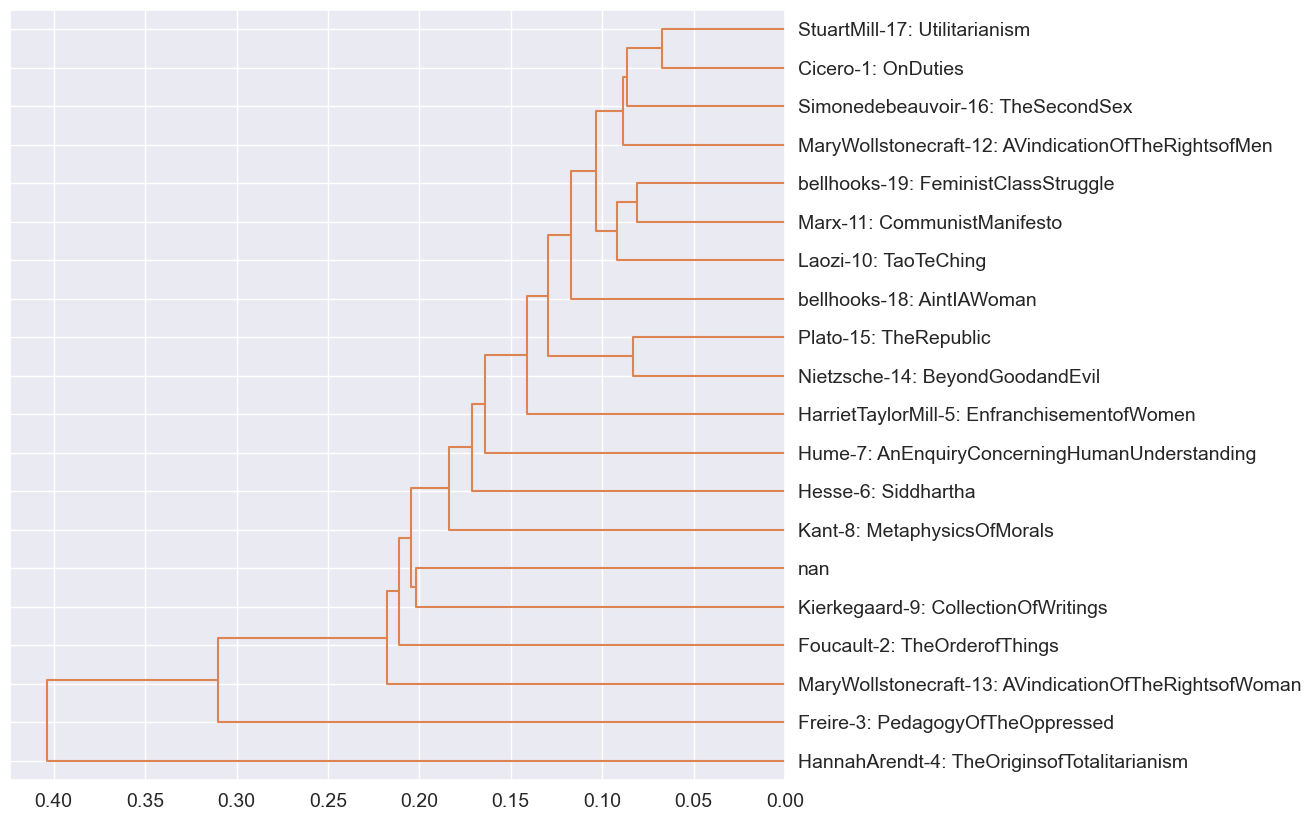

In [142]:
#cluster diagram for manhattan
hca(PAIRS.cityblock, color_thresh=8)

<Figure size 640x480 with 0 Axes>

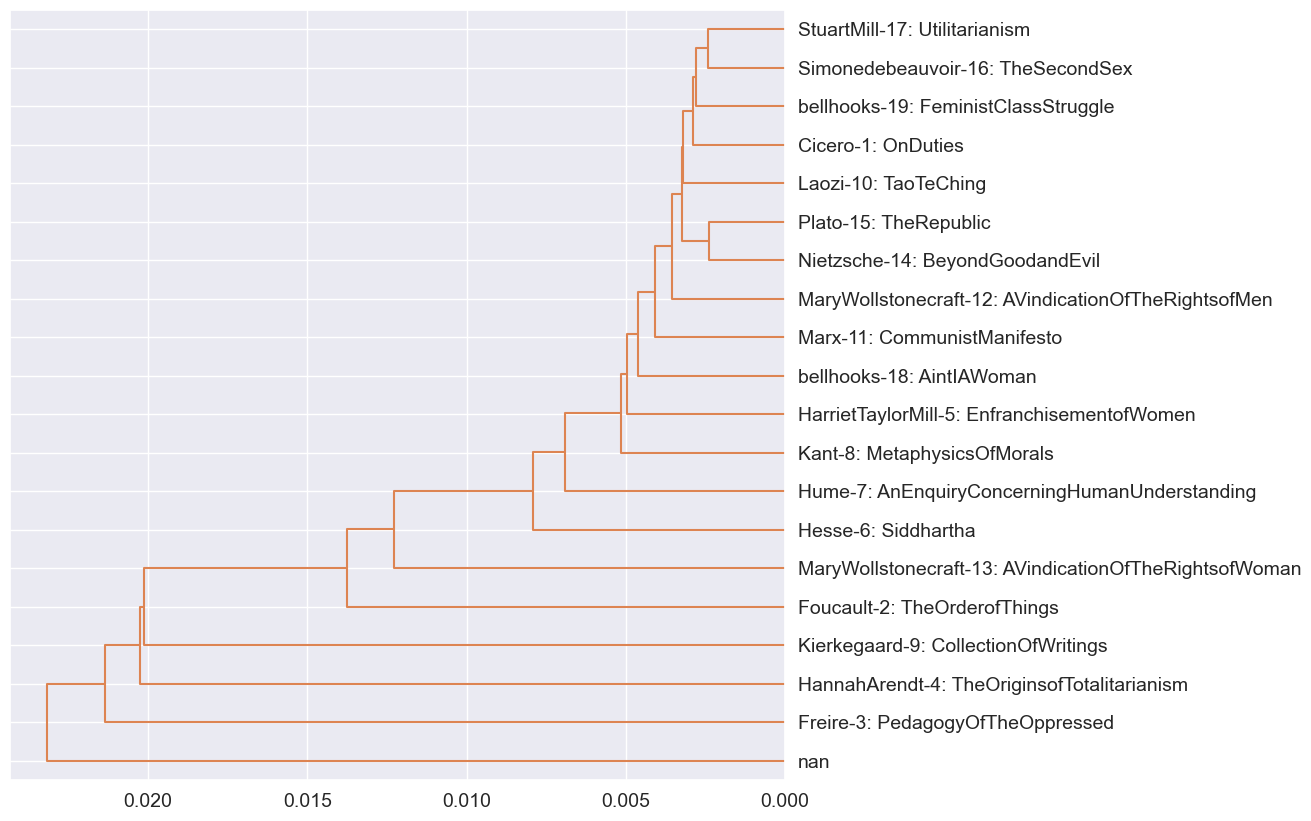

In [143]:
#cluster diagram for euclidean
hca(PAIRS.euclidean, color_thresh=.3)

<Figure size 640x480 with 0 Axes>

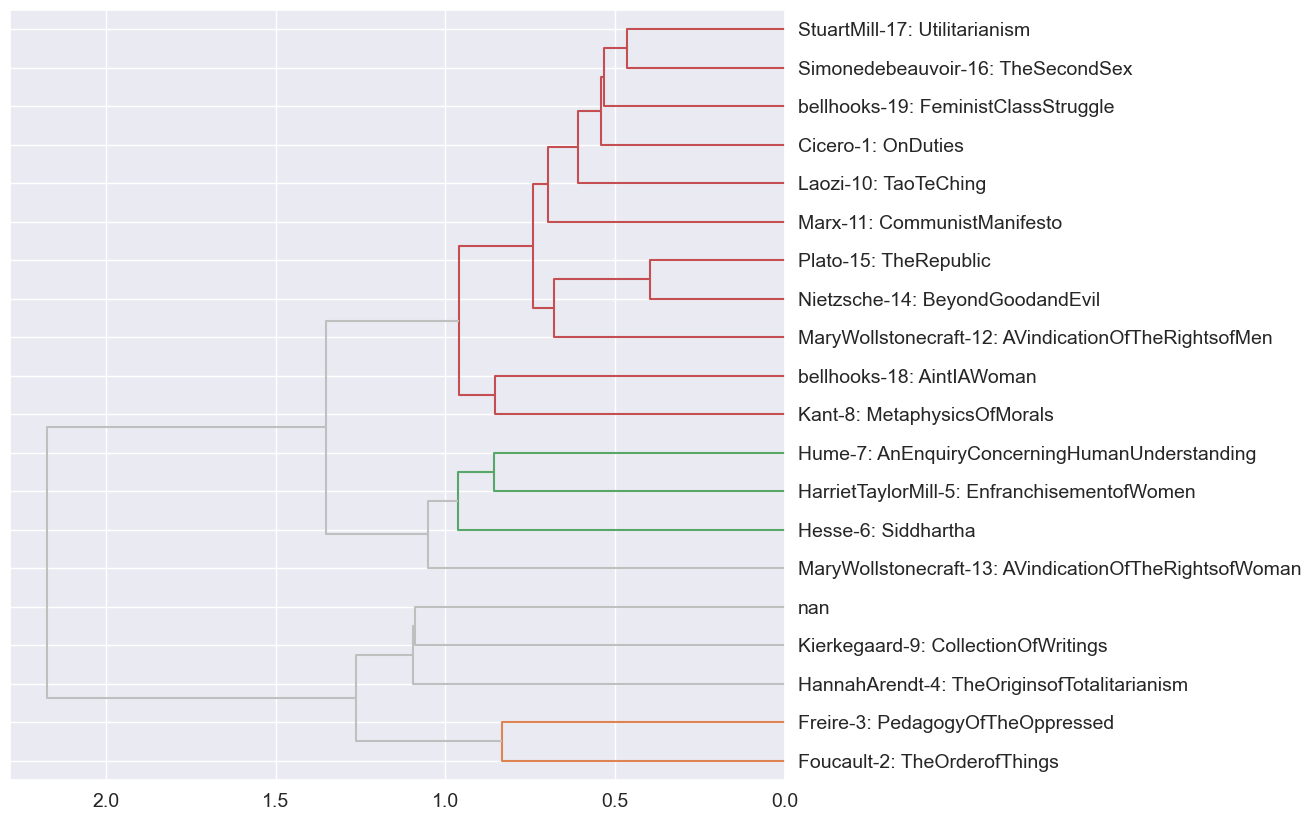

In [144]:
#cluster diagram for cosine
hca(PAIRS.cosine, color_thresh=1)

<Figure size 640x480 with 0 Axes>

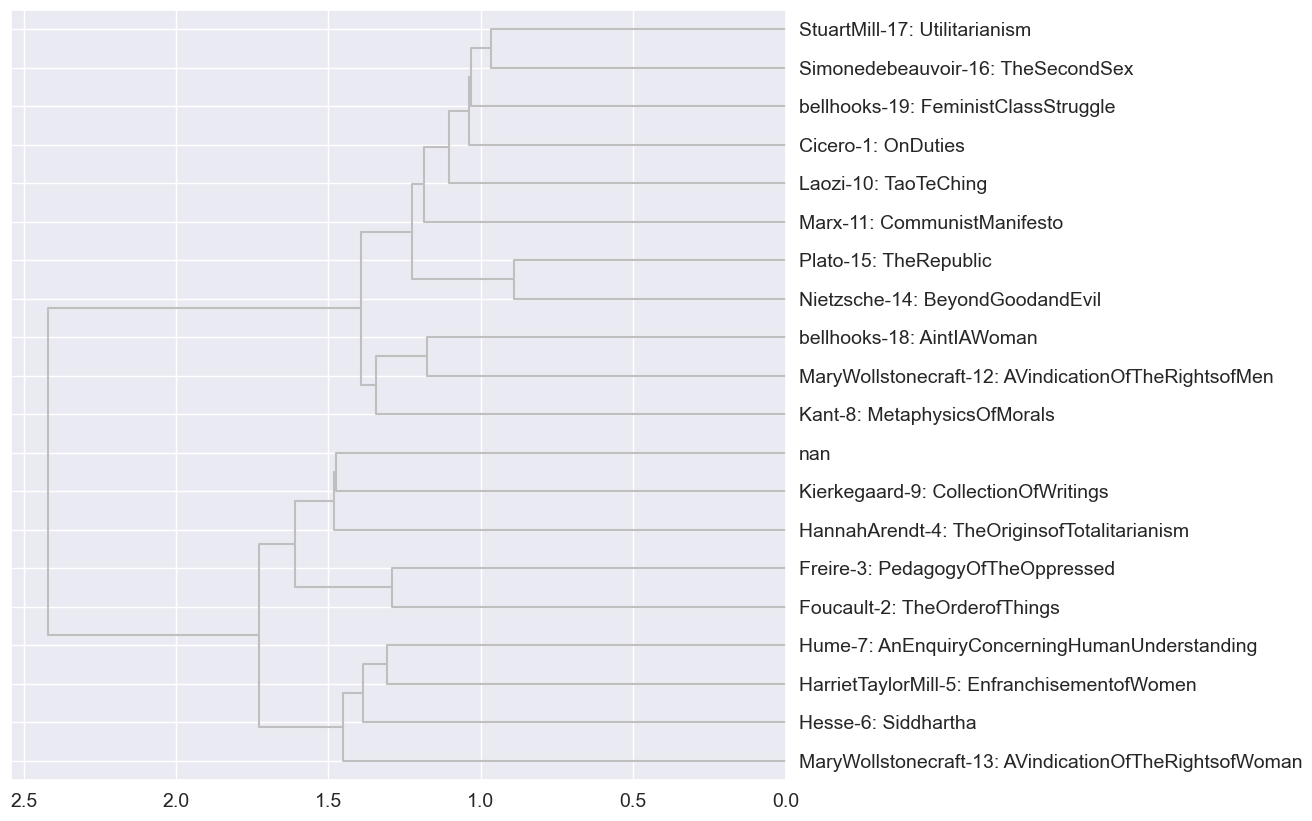

In [145]:
#cluster diagram for euclidean2
hca(PAIRS.euclidean2, color_thresh=.3)

<Figure size 640x480 with 0 Axes>

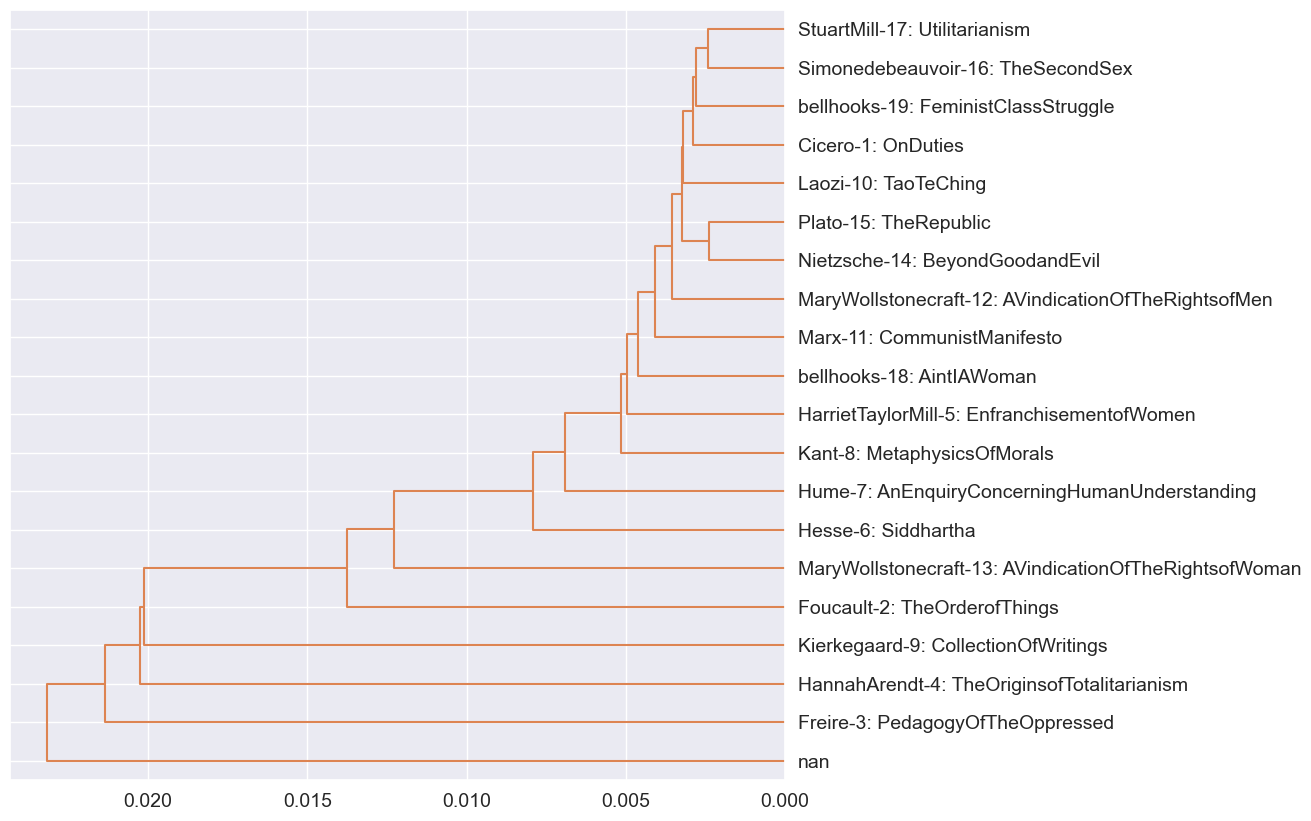

In [146]:
#cluster diagram for minkowski
hca(PAIRS.minkowski, color_thresh=.3)

#### Analysis & Recommendation